#Stereo Matching

NB: all the code waas done from scratch

The problem of recovering an accurate disparity map $L$ can be posed as an energy minimization problem:
$$ \mathcal{E}(L) = \sum_{p \in \mathcal{P}} D_p(l_p) + \lambda \sum_{p,q \in \mathcal{N}}V(l_p-l_q)$$
where $\mathcal{P}$ is the set of pixels, $\mathcal{N}$ is the set of undirected edges in the four-connected image grid graph and $l_p \in \{0,..,d_{max}\}$ is the disparsity value of a pixel $p$ (such that  $d_{max}$ is the maximum depth).

- $D_p(l_p)$ is the cost of assigning the label disparsity$l_p$ to pixel $p$ 

> With the truncated absolute intensity difference model (for $p=(x,y) \in \mathcal{P}$):
$$D_p(l_p) = min \left( \frac{1}{3}||I_{\mbox{left}}(y,x)-I_{\mbox{right}}(y,x-l_p),\tau \right) $$ 
where $\tau$ is a threshold .


- $V(l_p- l_q)$ is the cost of assigning labels $l_p$ and $l_q$ to two neighbor pixels $p$ and $q \in \mathcal{N}$.
> Potts model : 
$$V(x) = \mathbf{1}_{\{0\}}$$

## Imports

In [28]:
import numpy as np
import scipy.ndimage
import imageio
import matplotlib.pyplot as plt
from numpy.linalg import norm
from tqdm import tqdm

## Parameters

In [29]:
# Parameters
num_disp_values=16 
Lambda=10.0
nb_iterations=80

## Define costs :

In [ ]:
def compute_data_cost(I1, I2, num_disp_values, Tau):
    """data_cost: a 3D array of sixe height x width x num_disp_value;
    data_cost(y,x,l) is the cost of assigning the label l to pixel (y,x).
    The cost is min(1/3 ||I1[y,x]-I2[y,x-l]||_1, Tau)."""
    h,w,_ = I1.shape
    dataCost=np.zeros((h,w,num_disp_values))

    for lp in range(num_disp_values):
        dataCost[:, :, lp] = np.minimum(1./3*norm(I1 - np.roll(I2, lp, axis=1), axis=2, ord=1), Tau*np.ones((h, w)))

    return dataCost

In [ ]:
def compute_energy(dataCost,disparity,Lambda):
    """dataCost: a 3D array of sixe height x width x num_disp_values;
    dataCost(y,x,l) is the cost of assigning the label l to pixel (y,x).
    disparity: array of size height x width containing disparity of each pixel.
    (an integer between 0 and num_disp_values-1)
    Lambda: a scalar value.
    Return total energy, a scalar value"""
    h,w,num_disp_values = dataCost.shape

    hh, ww = np.meshgrid(range(h), range(w), indexing='ij')
    dplp = dataCost[hh, ww, disparity]

    # Unitary cost of assigning this disparity to each pixel
    energy = np.sum(dplp)

    # Compute interaction cost of each neighbors
    interactionCostU = Lambda*(disparity - np.roll(disparity, 1, axis=0) != 0)
    interactionCostL = Lambda*(disparity - np.roll(disparity, 1, axis=1) != 0)
    interactionCostD = Lambda*(disparity - np.roll(disparity, -1, axis=0) != 0)
    interactionCostR = Lambda*(disparity - np.roll(disparity, -1, axis=1) != 0)

    # Ignoring edge costs
    interactionCostU[0, :] = 0
    interactionCostL[:, 0] = 0
    interactionCostD[-1, :] = 0
    interactionCostR[:, -1] = 0

    # Adding interaction cost of each neighbors
    energy += np.sum(interactionCostU)
    energy += np.sum(interactionCostL)
    energy += np.sum(interactionCostD)
    energy += np.sum(interactionCostR)

    return energy

Given the data cost term $D_p(l_p)$ and the messages at iteration $t-1$, compute the new message $m^t_{p \longrightarrow q}(l_q)$

In [ ]:
def update_msg(msgUPrev,msgDPrev,msgLPrev,msgRPrev,dataCost,Lambda):
    """Update message maps.
    dataCost: 3D array, depth=label number.
    msgUPrev,msgDPrev,msgLPrev,msgRPrev: 3D arrays (same dims) of old messages.
    Lambda: scalar value
    Return msgU,msgD,msgL,msgR: updated messages"""
    msgU=np.zeros(dataCost.shape)
    msgD=np.zeros(dataCost.shape)
    msgL=np.zeros(dataCost.shape)
    msgR=np.zeros(dataCost.shape)

    h,w,num_disp_values = dataCost.shape

    msg_incoming_from_U = np.roll(msgDPrev, 1, axis=0)
    msg_incoming_from_L = np.roll(msgRPrev, 1, axis=1)
    msg_incoming_from_D = np.roll(msgUPrev, -1, axis=0)
    msg_incoming_from_R = np.roll(msgLPrev, -1, axis=1)

    npqU = dataCost + msg_incoming_from_L + msg_incoming_from_D + msg_incoming_from_R
    npqL = dataCost + msg_incoming_from_U + msg_incoming_from_D + msg_incoming_from_R
    npqD = dataCost + msg_incoming_from_L + msg_incoming_from_U + msg_incoming_from_R
    npqR = dataCost + msg_incoming_from_L + msg_incoming_from_D + msg_incoming_from_U

    spqU = np.amin(npqU, axis=2)
    spqL = np.amin(npqL, axis=2)
    spqD = np.amin(npqD, axis=2)
    spqR = np.amin(npqR, axis=2)

    for lp in range(num_disp_values):
        msgU[:, :, lp] = np.minimum(npqU[:, :, lp], Lambda + spqU)
        msgL[:, :, lp] = np.minimum(npqL[:, :, lp], Lambda + spqL)
        msgD[:, :, lp] = np.minimum(npqD[:, :, lp], Lambda + spqD)
        msgR[:, :, lp] = np.minimum(npqR[:, :, lp], Lambda + spqR)

    return msgU,msgD,msgL,msgR

Normalize messages to avoid overflow

In [ ]:
def normalize_msg(msgU,msgD,msgL,msgR):
    """Subtract mean along depth dimension from each message"""

    avg=np.mean(msgU,axis=2)
    msgU -= avg[:,:,np.newaxis]
    avg=np.mean(msgL,axis=2)
    msgL -= avg[:,:,np.newaxis]
    avg=np.mean(msgR,axis=2)
    msgR -= avg[:,:,np.newaxis]

    return msgU,msgD,msgL,msgR

In [ ]:
def compute_belief(dataCost,msgU,msgD,msgL,msgR):
    """Compute beliefs, sum of data cost and messages from all neighbors"""
    beliefs=dataCost.copy()

    msg_incoming_from_U = np.roll(msgD, 1, axis=0)
    msg_incoming_from_L = np.roll(msgR, 1, axis=1)
    msg_incoming_from_D = np.roll(msgU, -1, axis=0)
    msg_incoming_from_R = np.roll(msgL, -1, axis=1)

    beliefs += msg_incoming_from_D + msg_incoming_from_L + msg_incoming_from_R + msg_incoming_from_U

    return beliefs

Computes the MAP labeling $L$ at iteration $t$ based on the above beliefs

In [ ]:
def MAP_labeling(beliefs):
    """Return a 2D array assigning to each pixel its best label from beliefs
    computed so far"""
    return np.argmin(beliefs, axis=2)

In [ ]:
def stereo_bp(I1,I2,num_disp_values,Lambda,Tau=15,num_iterations=60):
    """The main function"""
    dataCost = compute_data_cost(I1, I2, num_disp_values, Tau)
    energy = np.zeros((num_iterations)) # storing energy at each iteration
    # The messages sent to neighbors in each direction (up,down,left,right)
    h,w,_ = I1.shape
    msgU=np.zeros((h, w, num_disp_values))
    msgD=np.zeros((h, w, num_disp_values))
    msgL=np.zeros((h, w, num_disp_values))
    msgR=np.zeros((h, w, num_disp_values))

    print('Iteration (out of {}) :'.format(num_iterations))
    for iter in tqdm(range(num_iterations)):
        #print('\t'+str(iter))
        msgU,msgD,msgL,msgR = update_msg(msgU,msgD,msgL,msgR,dataCost,Lambda)
        msgU,msgD,msgL,msgR = normalize_msg(msgU,msgD,msgL,msgR)
        # Next lines unused for next iteration, could be done only at the end
        beliefs = compute_belief(dataCost,msgU,msgD,msgL,msgR)
        disparity = MAP_labeling(beliefs)
        energy[iter] = compute_energy(dataCost,disparity,Lambda)

    return disparity,energy


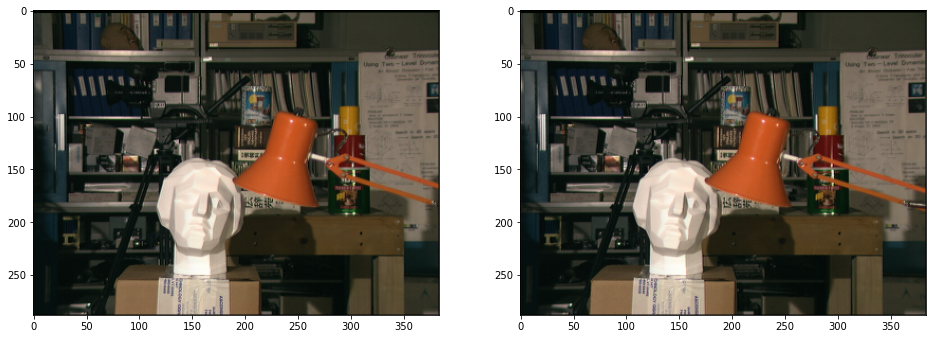

In [30]:
# Input
fig = plt.figure(figsize=(16,8))
img_left =imageio.imread('left.png')
img_right=imageio.imread('right.png')
plt.subplot(121)
plt.imshow(img_left)
plt.subplot(122)
plt.imshow(img_right)
plt.show()

In [31]:
# Convert as float gray images
img_left=img_left.astype(float)
img_right=img_right.astype(float)

# Gaussian filtering
I1=scipy.ndimage.filters.gaussian_filter(img_left, 0.6)
I2=scipy.ndimage.filters.gaussian_filter(img_right, 0.6)

disparity,energy = stereo_bp(I1,I2,num_disp_values,Lambda, num_iterations=nb_iterations)

  0%|          | 0/80 [00:00<?, ?it/s]

Iteration (out of 80) :


100%|██████████| 80/80 [00:31<00:00,  2.57it/s]


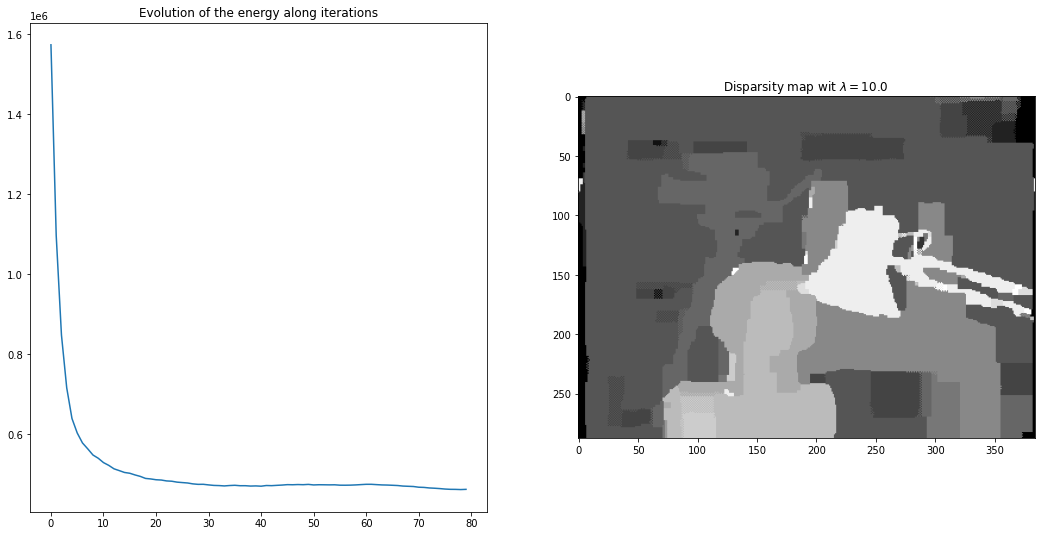

In [32]:
# Plot results
fig = plt.figure(figsize = (18,9))
plt.subplot(121)
plt.plot(energy)
plt.title("Evolution of the energy along iterations")
plt.subplot(122)
plt.imshow(disparity,cmap='gray',vmin=0,vmax=num_disp_values-1)
plt.title("Disparsity map wit $\lambda = $"+str(Lambda))
plt.show()